# Telco Churn Classification Project

## Acquire

Plan --- **Acquire** --- Prepare --- Explore --- Model --- Deliver

In [1]:
#import needed libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pydataset import data

#import ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [55]:
from sklearn.model_selection import train_test_split #train, test, split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [2]:
# acquire
from env import host, user, password
import acquire

In [3]:
# Create helper function to get the necessary connection url.

def get_connection(db_name):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    '''
    from env import host, user, password
    return f'mysql+pymysql://{user}:{password}@{host}/{db_name}'

In [4]:
#acquire function
def get_telco_churn_data():
    '''
    This function reads in the iris data from the Codeup db
    and returns a pandas DataFrame with all columns.
    '''
    
    sql_query = '''
    SELECT *
    FROM customers
    JOIN contract_types ON customers.contract_type_id = contract_types.contract_type_id
    JOIN payment_types ON customers.payment_type_id = payment_types.payment_type_id
    JOIN internet_service_types ON customers.internet_service_type_id = internet_service_types.internet_service_type_id
    '''
    return pd.read_sql(sql_query, get_connection('telco_churn'))

In [5]:
# call acquire function and take a look
df = get_telco_churn_data()

In [6]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,payment_type_id,monthly_charges,total_charges,churn,contract_type_id,contract_type,payment_type_id,payment_type,internet_service_type_id,internet_service_type
0,0016-QLJIS,Female,0,Yes,Yes,65,Yes,Yes,1,Yes,...,2,90.45,5957.9,No,3,Two year,2,Mailed check,1,DSL
1,0017-DINOC,Male,0,No,No,54,No,No phone service,1,Yes,...,4,45.20,2460.55,No,3,Two year,4,Credit card (automatic),1,DSL
2,0019-GFNTW,Female,0,No,No,56,No,No phone service,1,Yes,...,3,45.05,2560.1,No,3,Two year,3,Bank transfer (automatic),1,DSL
3,0056-EPFBG,Male,0,Yes,Yes,20,No,No phone service,1,Yes,...,4,39.40,825.4,No,3,Two year,4,Credit card (automatic),1,DSL
4,0078-XZMHT,Male,0,Yes,No,72,Yes,Yes,1,No,...,3,85.15,6316.2,No,3,Two year,3,Bank transfer (automatic),1,DSL


<hr style="border:2px solid black"> </hr>

## Prepare

Plan --- Acquire --- **Prepare** --- Explore --- Model --- Deliver

In [7]:
# import prepare

In [8]:
def prep_telco_churn(df):
    '''
    This function takes in the telco_churn df acquired by get_telco_churn_data
    Returns the telco_churn df.
    '''
    # drop duplicate columns from join
    df = df.loc[:, ~df.columns.duplicated()]
    
    # change data types
    df.total_charges = df.total_charges.str.replace(' ', '0').astype(float)
    df.replace({'churn': {'No':0, 'Yes':1}}, inplace=True)
    
    #drop duplicates
    df.drop_duplicates(inplace=True)

    #create dummies
    dummy_df = pd.get_dummies(df[['internet_service_type_id','contract_type_id']], dummy_na = False, drop_first=[True,True])
    #concat dummies with original df
    df= pd.concat([df, dummy_df], axis=1)

    return df

In [9]:
#reassign prep_telco_churn(df) to just df
df = prep_telco_churn(df)

In [10]:
#call df and look at it
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type,internet_service_type_id,contract_type_id
0,0016-QLJIS,Female,0,Yes,Yes,65,Yes,Yes,1,Yes,...,Yes,2,90.45,5957.90,0,Two year,Mailed check,DSL,1,3
1,0017-DINOC,Male,0,No,No,54,No,No phone service,1,Yes,...,No,4,45.20,2460.55,0,Two year,Credit card (automatic),DSL,1,3
2,0019-GFNTW,Female,0,No,No,56,No,No phone service,1,Yes,...,No,3,45.05,2560.10,0,Two year,Bank transfer (automatic),DSL,1,3
3,0056-EPFBG,Male,0,Yes,Yes,20,No,No phone service,1,Yes,...,Yes,4,39.40,825.40,0,Two year,Credit card (automatic),DSL,1,3
4,0078-XZMHT,Male,0,Yes,No,72,Yes,Yes,1,No,...,Yes,3,85.15,6316.20,0,Two year,Bank transfer (automatic),DSL,1,3


<hr style="border:2px solid black"> </hr>

## Explore

Plan --- Acquire --- Prepare --- **Explore** --- Model --- Deliver

In [11]:
#take a look at the data
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type,internet_service_type_id,contract_type_id
0,0016-QLJIS,Female,0,Yes,Yes,65,Yes,Yes,1,Yes,...,Yes,2,90.45,5957.90,0,Two year,Mailed check,DSL,1,3
1,0017-DINOC,Male,0,No,No,54,No,No phone service,1,Yes,...,No,4,45.20,2460.55,0,Two year,Credit card (automatic),DSL,1,3
2,0019-GFNTW,Female,0,No,No,56,No,No phone service,1,Yes,...,No,3,45.05,2560.10,0,Two year,Bank transfer (automatic),DSL,1,3
3,0056-EPFBG,Male,0,Yes,Yes,20,No,No phone service,1,Yes,...,Yes,4,39.40,825.40,0,Two year,Credit card (automatic),DSL,1,3
4,0078-XZMHT,Male,0,Yes,No,72,Yes,Yes,1,No,...,Yes,3,85.15,6316.20,0,Two year,Bank transfer (automatic),DSL,1,3


In [12]:
#data has int and object data types
#look at column names
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               7043 non-null   object 
 1   gender                    7043 non-null   object 
 2   senior_citizen            7043 non-null   int64  
 3   partner                   7043 non-null   object 
 4   dependents                7043 non-null   object 
 5   tenure                    7043 non-null   int64  
 6   phone_service             7043 non-null   object 
 7   multiple_lines            7043 non-null   object 
 8   internet_service_type_id  7043 non-null   int64  
 9   online_security           7043 non-null   object 
 10  online_backup             7043 non-null   object 
 11  device_protection         7043 non-null   object 
 12  tech_support              7043 non-null   object 
 13  streaming_tv              7043 non-null   object 
 14  streamin

### data summary:
- 18 object data types
- 8 integer data types
- 1 float data type
- 0 null values

In [13]:
#descriptive statistics
df.describe()

,senior_citizen,tenure,internet_service_type_id,contract_type_id,payment_type_id,monthly_charges,total_charges,churn,internet_service_type_id,contract_type_id
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,1.872923,1.690473,2.315633,64.761692,2279.734304,0.265370,1.872923,1.690473
std,0.368612,24.559481,0.737796,0.833755,1.148907,30.090047,2266.794470,0.441561,0.737796,0.833755
min,0.000000,0.000000,1.000000,1.000000,1.000000,18.250000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,9.000000,1.000000,1.000000,1.000000,35.500000,398.550000,0.000000,1.000000,1.000000
50%,0.000000,29.000000,2.000000,1.000000,2.000000,70.350000,1394.550000,0.000000,2.000000,1.000000
75%,0.000000,55.000000,2.000000,2.000000,3.000000,89.850000,3786.600000,1.000000,2.000000,2.000000
max,1.000000,72.000000,3.000000,3.000000,4.000000,118.750000,8684.800000,1.000000,3.000000,3.000000


In [14]:
#we are trying to determine churn... look into that
df.churn.value_counts()

#this shows 26.54% of customers churn (1869 out of 7043)

0    5174
1    1869
Name: churn, dtype: int64

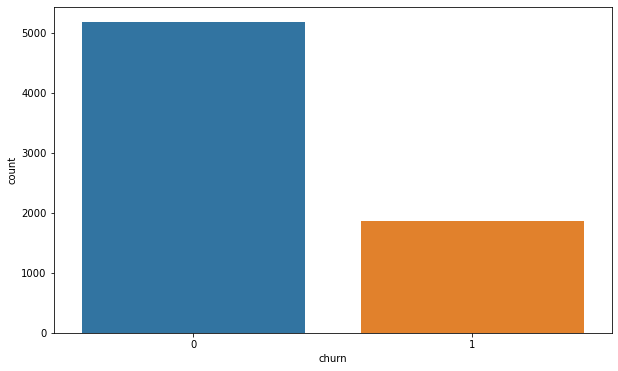

In [15]:
#visualize that data
plt.figure(figsize=(10,6))
sns.countplot(x='churn', data=df)
plt.show()

In [16]:
#find ou how many are senior citizens and how many are not
df.senior_citizen.value_counts()

#this shows that 16.21% of all customers are seniors (1142 out of 7043)

0    5901
1    1142
Name: senior_citizen, dtype: int64

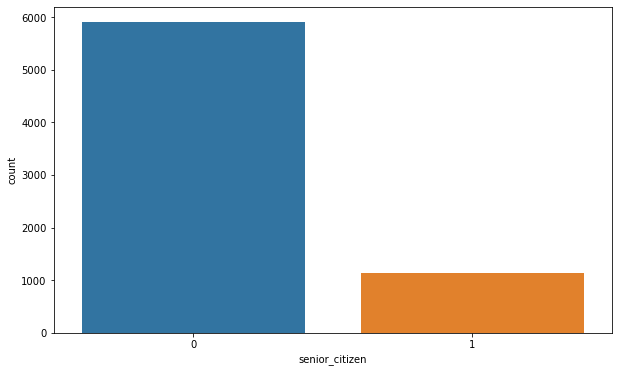

In [17]:
#visualize senior_citizen data
plt.figure(figsize=(10,6))
sns.countplot(x='senior_citizen', data=df)
plt.show()

In [18]:
#average tenure, max tenure, min tenure??
df.tenure.mean(), df.tenure.max(), df.tenure.min()

(32.37114865824223, 72, 0)

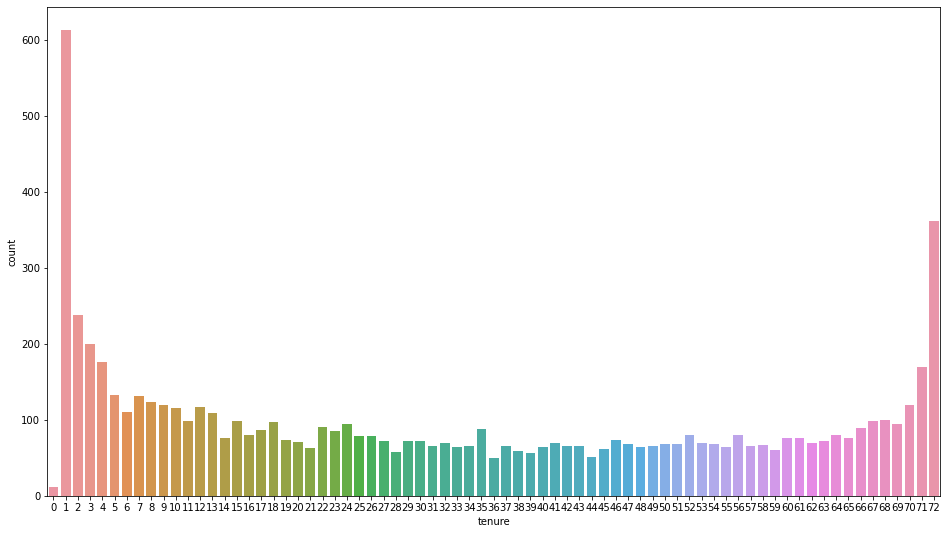

In [19]:
#visualize tenure data
plt.figure(figsize=(16,9))
sns.countplot(x='tenure', data=df)
plt.show()

In [20]:
#average monthly charges, max monthly charges, min monthly charges
df.monthly_charges.mean(), df.monthly_charges.max(), df.monthly_charges.min()

(64.76169246059882, 118.75, 18.25)

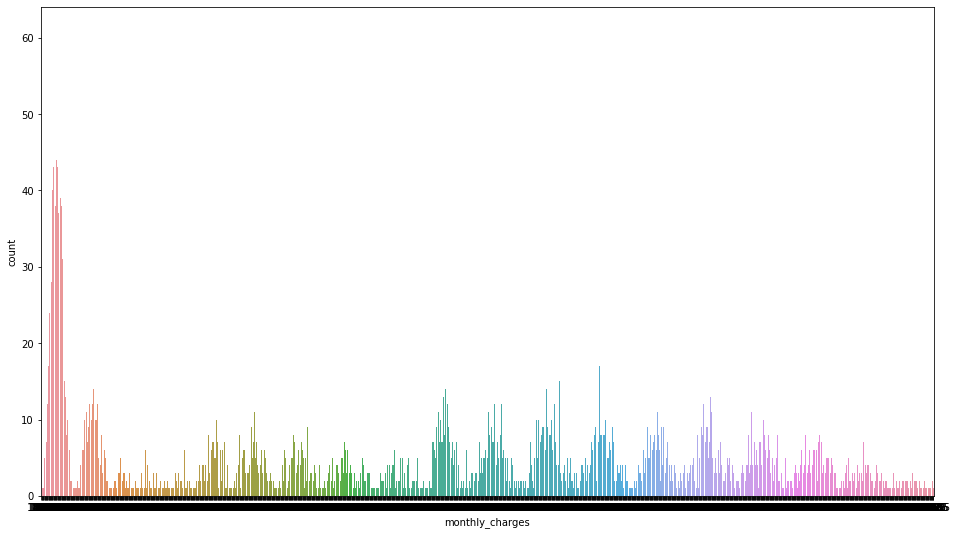

In [21]:
#visualize monthly charge data
plt.figure(figsize=(16,9))
sns.countplot(x='monthly_charges', data=df)
plt.show()

In [22]:
#identify columns for loop
columns = ['gender', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'internet_service_type_id',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract_type_id',
       'paperless_billing', 'payment_type_id', 'monthly_charges',
       'total_charges', 'churn', 'contract_type_id', 'contract_type',
       'payment_type_id', 'payment_type', 'internet_service_type_id',
       'internet_service_type']

In [24]:
#create for loop to print value counts for all columns
for col in columns:
    print(col)
    print(df[col].value_counts())
    print('----------------------------------------')

gender
Male      3555
Female    3488
Name: gender, dtype: int64
----------------------------------------
senior_citizen
0    5901
1    1142
Name: senior_citizen, dtype: int64
----------------------------------------
partner
No     3641
Yes    3402
Name: partner, dtype: int64
----------------------------------------
dependents
No     4933
Yes    2110
Name: dependents, dtype: int64
----------------------------------------
tenure
1     613
72    362
2     238
3     200
4     176
71    170
5     133
7     131
8     123
70    119
9     119
12    117
10    116
6     110
13    109
68    100
15     99
11     99
67     98
18     97
69     95
24     94
22     90
66     89
35     88
17     87
23     85
64     80
56     80
16     80
52     80
25     79
26     79
14     76
65     76
61     76
60     76
46     74
19     73
63     72
29     72
27     72
30     72
20     71
62     70
41     70
53     70
32     69
54     68
47     68
50     68
51     68
58     67
49     66
43     65
42     65
31     65

ValueError: Grouper for 'internet_service_type_id' not 1-dimensional

In [26]:
#find correlation- I think age correlates the most to churn
telco_correlation = df.corr()
telco_correlation
#this shows that senior_citizen and monthly_charges have the highest pos corr with churn

,senior_citizen,tenure,internet_service_type_id,contract_type_id,payment_type_id,monthly_charges,total_charges,churn,internet_service_type_id,contract_type_id
senior_citizen,1.000000,0.016567,-0.032310,-0.142554,-0.093704,0.220173,0.103006,0.150889,-0.032310,-0.142554
tenure,0.016567,1.000000,-0.030359,0.671607,0.340305,0.247900,0.826178,-0.352229,-0.030359,0.671607
internet_service_type_id,-0.032310,-0.030359,1.000000,0.099721,0.008124,-0.323260,-0.175755,-0.047291,1.000000,0.099721
contract_type_id,-0.142554,0.671607,0.099721,1.000000,0.358913,-0.074195,0.446855,-0.396713,0.099721,1.000000
payment_type_id,-0.093704,0.340305,0.008124,0.358913,1.000000,-0.074353,0.222398,-0.262818,0.008124,0.358913
monthly_charges,0.220173,0.247900,-0.323260,-0.074195,-0.074353,1.000000,0.651174,0.193356,-0.323260,-0.074195
total_charges,0.103006,0.826178,-0.175755,0.446855,0.222398,0.651174,1.000000,-0.198324,-0.175755,0.446855
churn,0.150889,-0.352229,-0.047291,-0.396713,-0.262818,0.193356,-0.198324,1.000000,-0.047291,-0.396713
internet_service_type_id,-0.032310,-0.030359,1.000000,0.099721,0.008124,-0.323260,-0.175755,-0.047291,1.000000,0.099721
contract_type_id,-0.142554,0.671607,0.099721,1.000000,0.358913,-0.074195,0.446855,-0.396713,0.099721,1.000000


In [27]:
#this gives the all the correlation with JUST churn
telco_corr_churn = telco_correlation['churn']
telco_corr_churn

## again, senior_citizen is the highest
##THIS will indict my DRIVER of churn!!

senior_citizen              0.150889
tenure                     -0.352229
internet_service_type_id   -0.047291
contract_type_id           -0.396713
payment_type_id            -0.262818
monthly_charges             0.193356
total_charges              -0.198324
churn                       1.000000
internet_service_type_id   -0.047291
contract_type_id           -0.396713
Name: churn, dtype: float64

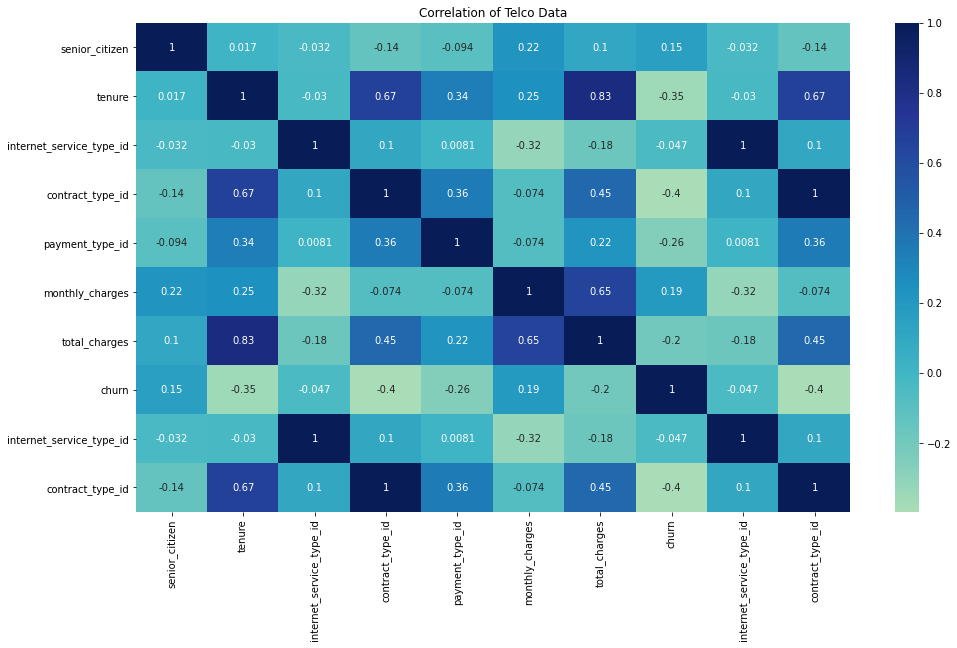

In [29]:
#heatmap to show correlation of all data
plt.figure(figsize=(16,9))

sns.heatmap(df.corr(), cmap='YlGnBu', center=0, annot=True)

plt.title('Correlation of Telco Data')

plt.show()

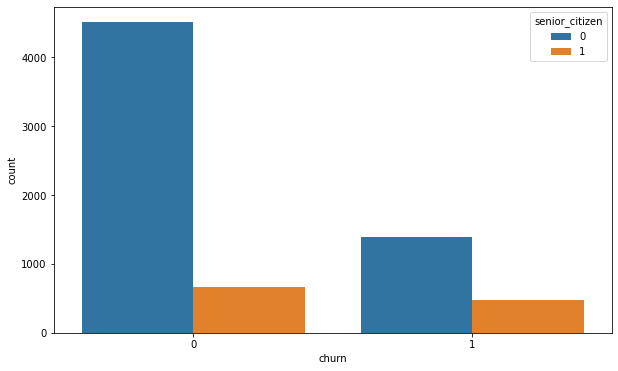

In [32]:
#this plot shows senior citizen (1) vs non-senior citizen (0)
## who churn (1) vs do not churn (0)
plt.figure(figsize=(10,6))
sns.countplot(x='churn', hue='senior_citizen', data=df)
plt.show()

_______________

### Find the appropriate statistical test to use
- churn (categorical) and senior_citizen (categorical)
- 2 discrete variables
- use chi2 testing

In [35]:
#create confusion matrix
observed = pd.crosstab(df.churn, df.senior_citizen)
observed

senior_citizen,0,1
churn,,
0,4508,666
1,1393,476


In [36]:
#set alpha
alpha = 0.05

In [37]:
#chi2 contingency returns 4 different values
chi2, p, degf, expected = stats.chi2_contingency(observed)
chi2, p, degf, expected

(159.42630036838742,
 1.510066805092378e-36,
 1,
 array([[4335.05239245,  838.94760755],
        [1565.94760755,  303.05239245]]))

In [38]:
## make it easier to read
print('Observed\n')
print(observed.values)
print('---------------------\nExpected\n')
print(expected.astype(int))
print('---------------------\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[4508  666]
 [1393  476]]
---------------------
Expected

[[4335  838]
 [1565  303]]
---------------------

chi^2 = 159.4263
p     = 0.0000


In [39]:
if p< alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


#### We reject $H_0$. Therefore, we believe that there is a relationship between churn and customer age

<hr style="border:2px solid black"> </hr>

## Modeling

Plan --- Acquire --- Prepare --- Explore --- **Model** --- Deliver

## Hypothosis:

- **$H_{0}$**: there is no relationship between churn and customer age
<br>

- **$H_{a}$**: there is a relationshp between churn and customer age
<br>

- **True Positive**: Predict there is a relationship and there is a relationship
<br>

- **True Negative**:Predict there is no relationship and there is not relationship
<br>

- **False Positive**: Predict there is a relationship and there is no relationship
<br>

- **False Negative**: Predict there is no relationship and there is a relationship

In [43]:
#split data
train, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train, test_size=.3, random_state=123)

In [45]:
#specify columns to use
X_col= ['senior_citizen','tenure', 'internet_service_type_id', 'contract_type_id']
y_col= 'churn'

In [47]:
#get sizes of sets
train.shape, validate.shape, test.shape

((3943, 26), (1691, 26), (1409, 26))

In [46]:
#specify train, validate, test
X_train = train[X_col]
y_train= train[y_col]

X_validate = validate[X_col]
y_validate= validate[y_col]

X_test = test[X_col]
y_test= test[y_col]

In [48]:
#shape of train set
X_train.shape, y_train.shape

((3943, 6), (3943,))

In [53]:
#create baseline
train['baseline_pred'] = 0

In [51]:
#obtain accuracy score for baseline
accuracy_score(train.churn, train.baseline_pred)

0.7311691605376617

_______________________

### Logistic Regression Model 

In [65]:
#Define the logistic regression model
logit = LogisticRegression(C=0.1, random_state= 123)

In [66]:
#fit the model with train data
logit.fit(X_train, y_train)

LogisticRegression(C=0.1, random_state=123)

In [67]:
#now use the model to make predictions
y_pred = logit.predict(X_train)

In [68]:
#classifcation report
pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.760637,0.626667,0.750444,0.693652,0.724622
recall,0.961152,0.177358,0.750444,0.569255,0.750444
f1-score,0.849219,0.276471,0.750444,0.562845,0.695246
support,2883.000000,1060.000000,0.750444,3943.000000,3943.000000


In [70]:
print('The accuracy of Logistic Regression classifier on training set: {:.2f}'.format(logit.score(X_train, y_train)))

The accuracy of Logistic Regression classifier on training set: 0.75


In [ ]:
import model_func
